In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
import pandas as pd
import csv
import os
import numpy
import copy
%matplotlib inline
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF, PCA
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from collections import Counter, defaultdict, OrderedDict
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

#Some nice plotting params
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 3
plt.style.use('ggplot')

# Load ISIS data set and clean tweets

In [5]:
df = pd.read_csv('/media/patrick/MY_EXTERNAL/ISIS/tweets.csv', parse_dates= [6])

In [6]:
df.username = df.username.str.lower()

In [34]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [35]:
def clean_tweet(tweet):
    ext = "http"
    text = tweet[:tweet.find(ext)].lower()
    text = re.sub("[^\S]", " ", text)
    text = re.sub("english translation ", "", text)
    textOnly = re.sub("[^a-zA-Z0-9@# ]", "", text)
    return(textOnly)

In [36]:
def remove_users(tweet):
    text = tweet.lower()
    textOnly = re.sub(r"@\w+", "", text)
    return(textOnly)

In [54]:
df.tweets = df.tweets.apply(clean_tweet)

In [84]:
infoDict = OrderedDict()
for r in df[['username','tweets']].iterrows():
    match = re.search('^rt', r[1][1])
    if match:
        m = list(re.findall(r"@\w+", r[1][1]))
        if m:
            username=m[0][1:]
            tweet=r[1][1][len('rt ' + m[0]):] +' @' + r[1][0]
    else:
        username=r[1][0]
        tweet=r[1][1]
    if username not in infoDict:
        user = {}
        user['affil'] = []
        user['hashtags'] = []
        user['tweets'] = []
        user['doc'] = ''
        infoDict[username] = user
    if tweet not in infoDict[username]['tweets']:
        infoDict[username]['tweets'].append(tweet)
        infoDict[username]['doc']+=' ' + tweet
    infoDict[username]['hashtags'].extend(re.findall('(?<=#)\w+', tweet))
    infoDict[username]['affil'].extend(re.findall('(?<=@)\w+', tweet))

### Treat all the tweets from one user as a single document and vectorize

In [85]:
len(infoDict)

1575

In [72]:
docs = [v['doc'] for k, v in infoDict.items()]

In [76]:
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize,
                                  ngram_range=(1,1), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_docs = Tfidf_vectorizer.fit_transform(docs)

In [ ]:
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1,3), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
cv_tweets = count_vectorizer.fit_transform(docs)

treat each tweets seperately

In [ ]:
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize,
                                  ngram_range=(1,2), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_tweets = Tfidf_vectorizer.fit_transform(df.tweets)

--------------------------------------------------------------------------

In [59]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(tfidf_docs, n_components=15,
                                      n_iter=5,
                                      random_state=None)

In [60]:
sigma = []
for k,v in enumerate(Sigma):
    sigma.append((k,v))

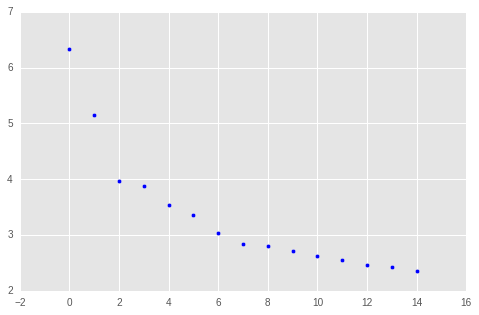

In [61]:
f = plt.scatter(*zip(*sigma))

Based on the sigma values from the resulting matrix we can choose a about 5 components to use in our NMF model in order to explain the most.....?

### NMF decomposition

In [62]:
tfidf_docs.shape

(1575, 25374)

In [77]:
num_topics = 6
model = NMF(n_components=num_topics, init='random', random_state=0)
nmf = model.fit_transform(tfidf_docs)

In [78]:
doc_cluster = [list(r).index(max(r)) for r in nmf]

In [81]:
print (doc_cluster[0:20])
print (doc_cluster[41:60])
print (doc_cluster[61:80])
print( doc_cluster[-40:-20])

[0, 0, 0, 5, 5, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5]
[5, 0, 5, 5, 5, 5, 0, 5, 0, 0, 3, 5, 0, 5, 5, 0, 0, 0, 0]
[4, 5, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 5, 2, 5, 4, 0, 0, 5]
[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [49]:
for tweet in df[df.username == 'wayf44rerr'].tweets:
    if 'insensibles79' in tweet:
        print(tweet)

rt @insensibles79 #khilafahfr #furat quallah accepte notre frre abou turab al russi 


In [82]:
infoDict['insensibles79']

{'affil': ['wayf44rerr'],
 'doc': '  #khilafahfr #furat quallah accepte notre frre abou turab al russi @wayf44rerr',
 'hashtags': ['khilafahfr', 'furat'],
 'tweets': [' #khilafahfr #furat quallah accepte notre frre abou turab al russi @wayf44rerr']}

In [83]:
cluster_size = [0,0,0,0,0,0]
for v in doc_cluster:
    cluster_size[v]+=1
cluster_size

[843, 43, 75, 55, 79, 480]

In [92]:
data = pd.DataFrame(infoDict).T

In [93]:
data.reset_index(inplace=True)

In [98]:
data['cluster'] = doc_cluster

In [79]:
# create dictionary that maps a user to their specific cluster
user_docs = {}
for k, cluster in enumerate(doc_cluster):
    user_docs[data['index'][k]] = cluster

In [108]:
words = sorted([(i,v) for v,i in Tfidf_vectorizer.vocabulary_.items()])
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])

In [106]:
# VINNY"S CODE!
# Create the a list of topic words but only inlude them if they are the highest among all clusters
# they also need to be weighted appropriately within their cluster


word_cluster = [(list(r).index(max(r)),max(r)) for r in model.components_.transpose()]
for i,r in enumerate(model.components_.transpose()):
    s = sorted(r)
    if (s[0]-s[1])/s[1]<0.25:
        word_cluster[i] = (-1,-1)
topic_words = []
for c in range(6):
    a = sorted([(v[1],i) for i,v in enumerate(word_cluster) if v[0]==c], reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])

In [107]:
topic_words

[[(4201, '@mobi_ayubi'),
  (975, '#isis'),
  (15366, 'killed'),
  (1924, '#syria'),
  (964, '#is'),
  (4865, '@uncle_samcoco'),
  (14533, 'isis')],
 [(4490, '@ramiallolah'),
  (2523, '400'),
  (4101, '@maghrebiq'),
  (3559, '@freedaraa11'),
  (5432, 'afghani'),
  (21288, 'selfies'),
  (16695, 'memo')],
 [(0, '#'),
  (2818, '@abubakerdimshqi'),
  (4729, '@suspend_me_fags'),
  (2967, '@alamreeki4'),
  (2912, '@afriqqiya_252'),
  (3374, '@dabiqsweetsman'),
  (2678, '@04_8_1437')],
 [(4938, '@wayf44rerr'),
  (8050, 'bismillah'),
  (2269, '11'),
  (7489, 'b52'),
  (2667, '942016'),
  (4939, '@wayff44rer'),
  (20719, 'rural')],
 [(4926, '@warrnews'),
  (3849, '@jazrawi_saraqib'),
  (11770, 'f16'),
  (2597, '64'),
  (760, '#gaza'),
  (11125, 'earthquake'),
  (12083, 'fighter')],
 [(4152, '@melvynlion'),
  (2833, '@abuhumayra4'),
  (6146, 'allah'),
  (6597, 'amp'),
  (3721, '@ibnkashmir_'),
  (17426, 'muslims'),
  (14552, 'islam')]]

-----

## Creating Graph Edges

#### Currently: 
We have occurences of username strings in all tweets from each user


#### We would like: 
agrregated pairwise co-occurrence of character strings in tweet for each username, Normalized by the sum of all tweet from both usernames being compared.

In [109]:
def is_retweet(tweet):
    match = re.search('^rt', tweet)
    if match:
        return True
    return False

In [110]:
def check_string(string):
    return string in df.username.unique()

In [111]:
count=0
rt = []
for tweet in df.tweets:
    m = re.findall(r"^rt @", tweet)
    if m:
        count+=1
        rt.append(tweet)
count
#len(set(rt))

5824

NODES

In [80]:
# create the nodes for the graph. Dictionary keys as usernames 
# with each item in the value list being a connection with number of times mentioned
# NOTE!! this is for every mentioned user



nodes = defaultdict(str)
for K, V in infoDict.items():
    nodes[K] = [(k, v) for k,v in Counter(list(V['affil'])).items() if k != K]

In [81]:
matches = 0
for k, v in list(nodes.items()):
    if not v:
        del nodes[k]
        
    for i in range(len(v)):
        if v[i][0] == k:
            matches+=1
            v.remove(v[i])

In [48]:
# create the nodes for the graph. Dictionary keys as usernames 
# with each item in the value list being a connection with number of times mentioned
# NOTE!! this is only for users within the starting data set

nodes = defaultdict(str)
for K, V in infoDict.items():
    nodes[K] = [(k, v) for k,v in Counter(list(filter(check_string, (V['affil'])))).items() if k != K]
for k, v in list(nodes.items()):
    if not v:
        del nodes[k]

In [83]:
#create dictionary that maps usernames to a uniqe ID and the cluster they belong to
# user_docs = a list of documents per user

ID = defaultdict()
for k, v in enumerate(list(nodes.items())):
    ID[v[0]] = k, user_docs[v[0]]
    for i in range(0, len(v[1])):
        try:
            ID[v[1][i][0]] = k, user_docs[v[1][i][0]]
        except:
            pass

In [84]:
df2 = pd.DataFrame(ID).T

In [97]:
# save the nodes as a csv
pd.DataFrame(ID).T.to_csv('/media/patrick/MY_EXTERNAL/ISIS/nodes3.csv')

In [98]:
# create dict with a source, target tied to a weight
edge_dict = {}
for k, v in nodes.items():
    for i in range(len(v)):
        try:
            edge_dict[ID[[k][0]][0], ID[v[i][0]][0]] = v[i][1]
        except:
            pass

In [100]:
pd.DataFrame([[k[0],k[1],v] for k, v in edge_dict.items()]).to_csv('/media/patrick/MY_EXTERNAL/ISIS/edges3.csv')

In [ ]:
for k, v in edgeDict.items():
    edgeDict[k] = [word for item in v for word in item if word in list(set(df.username))]
for k, v in list(edgeDict.items()):
    if not v:
        del edgeDict[k]

In [ ]:
for k, v in edgeDict.items():
    for name in v:
        if name == k:
            v.remove(name)

-----

In [101]:
infoDict['whitecat_7']

{'affil': ['khadijavf',
  'joinisnation82',
  'princessbaqiya2',
  'jazrawi3uud',
  'endoftimes411',
  'princessbaqiya2',
  'wakasfahad10',
  'lionerr20',
  'skjfgyi7r6',
  'w97788',
  'croxetti',
  'proj32',
  'wilayathalab',
  'abuq14',
  'abuadamm',
  'skxx59',
  'skxx59',
  'wilayathalab',
  'croxetti',
  'proj32',
  'wilayathalab',
  'abuq14',
  'abuadamm',
  'ibnunoran8',
  'etdz101010',
  'haditha21',
  'wilayathalab',
  'abuadamm',
  'haditha21',
  'ibnunoran8',
  'etdz101010',
  'wilayathalab',
  'abuadamm',
  'haditha21',
  'ibnunoran8',
  'etdz101010',
  'wilayathalab',
  'abuadamm',
  'haditha21',
  'ibnunoran8',
  'etdz101010',
  'wilayathalab',
  'abuadamm',
  'haditha21',
  'ibnunoran8',
  'etdz101010',
  'wilayathalab',
  'abuadamm',
  'mrrman2',
  'abuadamm',
  'etdz101010',
  'haditha21',
  'ibnunoran8',
  'wilayathalab',
  'mrrman2',
  'abuadamm',
  'etdz101010',
  'haditha21',
  'ibnunoran8',
  'haditha21',
  'haditha21',
  'ibnunoran8',
  'etdz101010',
  'wilayatha

Time series analysis of all tweets grouped by day

In [7]:
df.time = pd.to_datetime(df.time)

In [212]:
from scipy import interpolate
import seaborn as sns

In [129]:
def movingaverage(interval, window_size):
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

In [12]:
perhr = df.set_index(df['time']).resample('D', how='count')

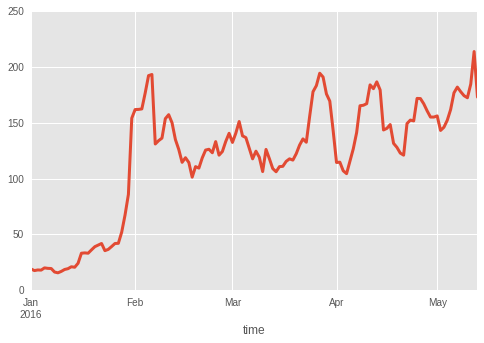

In [13]:
pd.rolling_mean(perhr, window=7).tweets['2016-01-01':].plot()

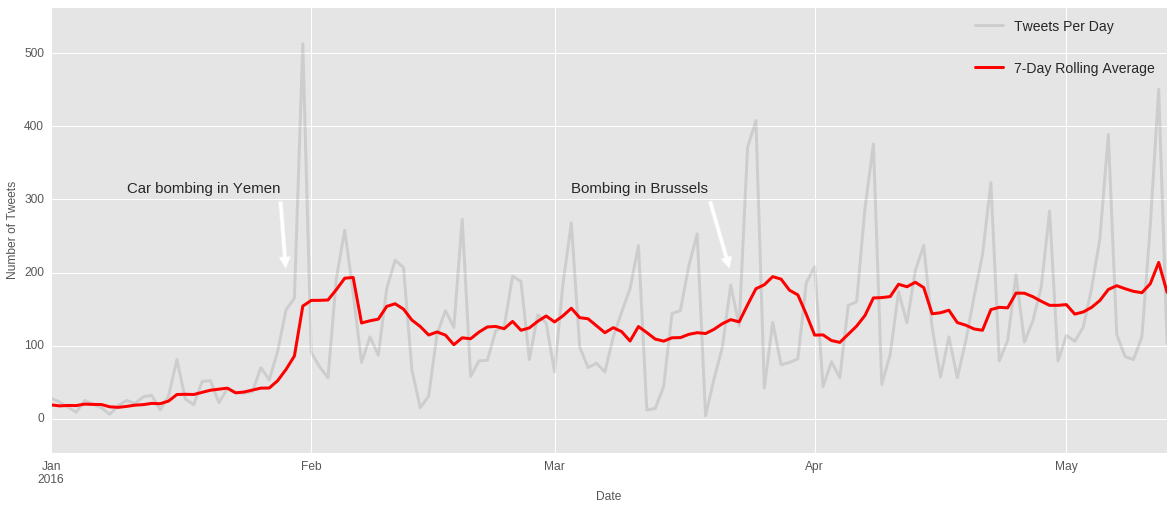

In [217]:
fig, ax = plt.subplots(figsize = (20,8))

perhr['2016-01-01':].numberstatuses.interpolate(method='linear').plot(ax = ax, color="black", fontsize=12, alpha=0.1)
pd.rolling_mean(perhr, window=7).tweets['2016-01-01':].plot(color ='r')

#sns.timeseries(perhr, ax=ax)

yemen = '2016-01-29'
brussels = '2016-03-22'


# ax.plot(yemen,183,color = 'r',
#         marker = 'o',
#         markersize = 20, 
#         linestyle = '',
#        markeredgewidth = 1.5
#        )

# ax.plot(brussels,183,color = 'r',
#         marker = 'v',
#         markersize = 20, 
#         linestyle = '',
#        markeredgewidth = 1.5
#        )


ax.annotate('Bombing in Brussels',xy=(brussels, 200),xytext=('2016-03-03', 310),
            arrowprops=dict(facecolor='white', shrink=0.05), size=15)

ax.annotate('Car bombing in Yemen',xy=(yemen, 200),xytext=('2016-01-10', 310),
            arrowprops=dict(facecolor='white', shrink=0.05),size=15)

ax.margins(None,0.1)
ax.legend(['Tweets Per Day','7-Day Rolling Average'], loc = 'upper right',
           numpoints = 1, labelspacing = 2.0, fontsize = 14)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
#ax.set_title('Frequency of ISIS Tweets in 2016')

# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w') 
# ax.spines['right'].set_color('w')
# ax.spines['left'].set_color('w')

# ax.tick_params(axis='x', colors='w')
# ax.tick_params(axis='y', colors='w')

# ax.yaxis.label.set_color('w')
# ax.xaxis.label.set_color('w')

# ax.set_axis_bgcolor('w')
fig.savefig('temp.png')
plt.show()

In [161]:
data2 = pd.DataFrame(columns=['username', 'tweets'])
for r in data.iterrows():
    for tweet in r[1][4]:
        #print(r[1][0])
        #temp = pd.DataFrame([[r[1][0], tweet]], columns=['username', 'tweets'])
        data2 = data2.append(pd.DataFrame([[r[1][0], tweet]], columns=['username', 'tweets'] ), ignore_index=True)

In [ ]:
data2['topic'] = np.argmax(model.transform(Tfidf_vectorizer.transform(data2.tweets)), axis=1)

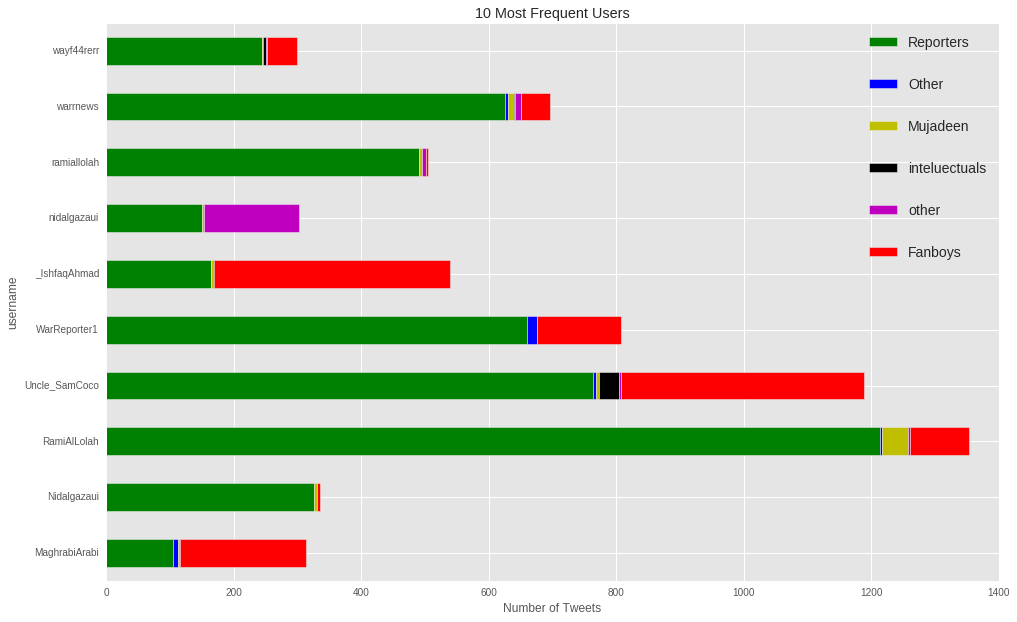

In [223]:
fig, ax = plt.subplots(figsize = (20,15))
my_colors = 'gbykmr'

top10_users = data2[data2.username.isin(data2.username.value_counts()[:10].keys().tolist())]
tb = pd.crosstab(top10_users.username, top10_users.topic)
tb['sum'] = tb.sum(axis=1)
pd.crosstab(top10_users.username, top10_users.topic).plot(kind='barh',stacked=True, figsize=(16, 10), color=my_colors, ax = ax)
#tb.sort_values('sum', ascending=False).iloc[:,:5].plot(kind='barh',stacked=True, figsize=(16, 10), colormap="Dark2", ax =ax)



ax.legend(['Reporters','Other','Mujadeen','inteluectuals','other','Fanboys'], loc = 'upper right', numpoints = 1, labelspacing = 2.0, fontsize = 14)
ax.set_title('10 Most Frequent Users')
ax.set_xlabel('Number of Tweets')